In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import numpy as np
import time

class W_D(nn.Module):
    def __init__(self,         
                 deep_in_dim=63, 
                 action_dim=3, 
                 num_embedding=100, 
                 embed_dim=16, 
                 deep_neurons=[32, 16], 
                 activation=nn.ReLU()):
        
        super(W_D, self).__init__()
        self.context_dim = 1 + deep_in_dim
        self.action_dim = action_dim
        self.z_dim = embed_dim + deep_neurons[-1]
        self.activation = activation
        
        self.wide = nn.Embedding(num_embedding, embed_dim)
        
        deep_dict = OrderedDict([])
        in_features = deep_in_dim
        for i, out_features in enumerate(deep_neurons):
            deep_dict[f"fc{i}"] = nn.Linear(in_features, out_features)
            deep_dict[f"activation{i}"] = activation
            in_features = out_features

        self.deep = nn.Sequential(deep_dict)
        # define the final layer
        self.lastlayer = nn.Linear(self.z_dim, self.action_dim)
        
    def forward(self, x):
        
        z = self.get_z(x)
        out = self.activation(self.lastlayer(z))
        return out
    
    def get_z(self, x):
        w_in = x[:,0].long()
        w_out = self.wide(w_in)
        d_in = x[:,1:]
        d_out = self.deep(d_in)
        z = torch.cat((w_out, d_out),dim=1)
        return z
        

class ContextualBandit():
    
    def __init__(self, device, model, optimizer, loss_func, algorithm):
        self.device = device
        self.model = model.to(device)
        self.context_dim = model.context_dim
        self.z_dim = model.z_dim
        self.action_dim = model.action_dim
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.algorithm = algorithm
        self.reset()
        
    def reset(self):
        self.dataset = []
    
    def observe_data(self, context_source):
        x_t = np.array(context_source)
        assert x_t.shape == (self.action_dim, self.context_dim)
        return x_t 
    
    def get_reward(self, reward_source, a_t):
        r_t = float(reward_source[a_t])
        return r_t

    def run(self, context_source, reward_source):
        x_t = self.observe_data(context_source) # x_t np.array size=(action_dim, context_dim)
        x_t_tensor = torch.tensor(x_t).float().to(self.device)
        z_t = self.model.get_z(x_t_tensor).detach().cpu().numpy() # z_t np.array size=(action_dim, context_dim)
        a_t = self.algorithm.select_action(z_t) # a_t int range (0, action_dim)
        r_t = self.get_reward(reward_source, a_t) # r_t float either from an online simulation or from a reward vertor(size=action_dim)  
        data = (x_t[a_t], z_t[a_t], a_t, r_t)
        self.dataset.append(data)
        self.algorithm.update(data) # update selection strategy (parameters of algorithm)
        
        return a_t
    
    def train(self, start_index=0, batch_size=16, num_epoch=100):
        # prepare dataset and dataloader for training
        train_dataset = BanditDataset(self.dataset[start_index:])
        train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        # train num_epoch epoches
        for i in range(num_epoch):
            for data_batch in train_dataloader:
                contexts, _, actions, rewards = data_batch
                contexts = contexts.float().to(self.device)
                actions = actions.long().to(self.device)
                rewards = rewards.float().to(self.device)
                outputs = model(contexts)
                pred_rewards = outputs[range(outputs.shape[0]),actions]
                loss = self.loss_func(pred_rewards, rewards)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()                
        # update algorithm's parameters after training
        self.algorithm.reset()
        for data in self.dataset:
            x_t_a_t, _, a_t, r_t = data
            x_t_a_t_tensor = torch.tensor(x_t_a_t).float().unsqueeze(0).to(self.device)
            with torch.no_grad():
                z_t_a_t = self.model.get_z(x_t_a_t_tensor).detach().cpu().numpy().reshape(-1)
            self.algorithm.update((x_t_a_t, z_t_a_t, a_t, r_t))
    
class BanditDataset(torch.utils.data.Dataset):
    
    def __init__(self, raw_dataset):
        self.dataset = raw_dataset
        
    def __getitem__(self, index):
        context, z, action, reward = self.dataset[index]
        return np.array(context), np.array(z), action, reward
    
    def __len__(self):
        return len(self.dataset)
    
class LinUCB():
    
    def __init__(self, z_dim, action_dim, delta=0.05):
        self.action_dim = action_dim
        self.z_dim = z_dim
        self.alpha = 1.0 + np.sqrt(np.log(2 / delta) / 2)
        self.reset()
    
    def reset(self):
        self.A = [np.eye(self.z_dim) for i in range(self.action_dim)]
        self.b = [np.zeros(self.z_dim) for i in range(self.action_dim)]
    
    def select_action(self, z_t):
        theta = np.zeros((self.action_dim, self.z_dim))
        ucb = np.zeros(self.action_dim)
        for a in range(self.action_dim):
            A_inv = np.linalg.inv(self.A[a])
            theta[a] = np.dot(A_inv, self.b[a])
            ucb[a] = np.dot(z_t[a], theta[a]) + self.alpha * np.sqrt(np.dot(np.dot(z_t[a], A_inv), z_t[a]))
        
        return np.argmax(ucb)
    
    def update(self, data):
        _, z_t_a_t, a_t, r_t = data
        assert z_t_a_t.shape == (self.z_dim, )
        assert type(a_t) == np.int64
        assert type(r_t) == float
        self.A[a_t] += np.dot(z_t_a_t.reshape((self.z_dim, 1)), z_t_a_t.reshape((1, self.z_dim)))
        self.b[a_t] += r_t * z_t_a_t
    
    
class TS():
    
    def __init__(self, ):
        pass
    
    def reset(self, ):
        pass
    
    def select_action(self, ):
        pass
    
    def update(self, ):
        pass


In [2]:
import pandas as pd
import numpy as np
file_path = "/content/drive/MyDrive/Fellowship.AI/P1_bandit/data_snippet.csv"
df = pd.read_csv(file_path)
df.head()

,riid,opened,rev_3dv2,unsub,campaign_type,retention_score,recency_score,frequency_score
0,242697842,1,75.00,0,Dedicated,14.000000,1.637422,31
1,275469002,1,75.00,0,Dedicated,2.800000,0.000000,0
2,4319542,1,19.98,0,Dedicated,1.000000,0.084239,4
3,166170102,1,19.98,0,Dedicated,0.756757,0.010870,1
4,6998482,1,150.00,0,Dedicated,28.000000,1.845885,18


In [3]:
len(df)

6240490

In [4]:
num_data = 100000
indices = np.random.choice(len(df),size=num_data)
df_subset = df.iloc[indices]

In [5]:
vocab = {riid:i for i, riid in enumerate(df_subset.riid.unique())}

In [6]:
len(vocab)

87455

In [7]:
user_ids = df_subset.riid.apply(lambda x:vocab[x])
c_t = pd.get_dummies(df_subset.campaign_type)

In [8]:
datasource = pd.DataFrame()
datasource['user_ids'] = user_ids

In [9]:
datasource = pd.concat((datasource, c_t),axis=1)

In [10]:
datasource[["retention_score",	"recency_score",	"frequency_score"]] = df_subset[["retention_score",	"recency_score",	"frequency_score"]]

In [11]:
datasource

,user_ids,Brand,Collection,Core,Dedicated,Innovation Spotlight,New Arrivals,Other,Product Spotlight,Replen,Tops,Trend,retention_score,recency_score,frequency_score
1959596,0,0,0,0,1,0,0,0,0,0,0,0,4.666667,0.402562,9
89701,1,0,0,1,0,0,0,0,0,0,0,0,4.666667,0.267857,5
3300811,2,0,0,0,1,0,0,0,0,0,0,0,0.823529,0.010870,1
2007318,3,0,0,0,0,1,0,0,0,0,0,0,3.500000,0.589868,29
729105,4,0,0,1,0,0,0,0,0,0,0,0,3.111111,0.153727,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424174,87451,1,0,0,0,0,0,0,0,0,0,0,28.000000,3.428183,70
2428826,87452,0,0,0,0,0,0,0,0,0,0,1,28.000000,1.491071,5
3185285,87453,1,0,0,0,0,0,0,0,0,0,0,5.600000,0.407803,16
622949,87454,0,0,0,1,0,0,0,0,0,0,0,14.000000,0.237966,6


In [12]:
rewardsource = pd.DataFrame()
rewardsource["reward_send"] = df_subset.opened * 1.2 - 0.2 + (df_subset.rev_3dv2 > 0) + df_subset.rev_3dv2/75.0 - 5.0*df_subset.unsub
rewardsource["reward_not_send"] = -rewardsource["reward_send"]

In [13]:
rewardsource

,reward_send,reward_not_send
1959596,1.0,-1.0
89701,1.0,-1.0
3300811,-0.2,0.2
2007318,1.0,-1.0
729105,1.0,-1.0
...,...,...
2424174,1.0,-1.0
2428826,1.0,-1.0
3185285,1.0,-1.0
622949,1.0,-1.0


In [22]:
opt_a = (rewardsource['reward_send'] < 0).astype(int)

In [23]:
opt_a

1959596    0
89701      0
3300811    1
2007318    0
729105     0
          ..
2424174    0
2428826    0
3185285    0
622949     0
260866     0
Name: reward_send, Length: 100000, dtype: int64

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [17]:
model = W_D(deep_in_dim=14, action_dim=2, num_embedding=len(vocab), deep_neurons=[128, 64]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()
algorithm = LinUCB(model.z_dim, model.action_dim, delta=0.05)
CB = ContextualBandit(device, model, optimizer, loss_func, algorithm)

train_batch_size = 64
num_epoch = 100

contexts = datasource.values
reward_vectors = rewardsource.values
opt_actions = opt_a.values

train_start_index = 0
start_time = time.time()
pred_actions = []
for t in range(num_data):
    context_source = np.array([contexts[t] for i in range(model.action_dim)])
    reward_source = reward_vectors[t]
    pred_a = CB.run(context_source, reward_source)
    pred_actions.append(pred_a)
    if (t+1)%1000 == 0:
        CB.train(start_index=train_start_index, batch_size=train_batch_size, num_epoch=num_epoch)
        train_start_index = t + 1
        print("{} --- {} seconds ---".format(t+1,(time.time() - start_time)))
        start_time = time.time()

cum_rewards_pred_action = []
cum_rewards_opt_action = []
p_i = 0
o_i = 0
for i in range(num_data):
    p_i += reward_vectors[i][pred_actions[i]]
    o_i += reward_vectors[i][opt_actions[i]]
    cum_rewards_pred_action.append(p_i)
    cum_rewards_opt_action.append(o_i)

1000 --- 6.512449026107788 seconds ---
2000 --- 6.609957218170166 seconds ---
3000 --- 7.1211323738098145 seconds ---
4000 --- 7.5754334926605225 seconds ---
5000 --- 8.490346908569336 seconds ---
6000 --- 8.84685206413269 seconds ---
7000 --- 9.481447219848633 seconds ---
8000 --- 9.780700445175171 seconds ---
9000 --- 9.808608055114746 seconds ---
10000 --- 10.160597562789917 seconds ---
11000 --- 10.738828420639038 seconds ---
12000 --- 10.976967334747314 seconds ---
13000 --- 11.423095703125 seconds ---
14000 --- 12.14676570892334 seconds ---
15000 --- 12.634242296218872 seconds ---
16000 --- 12.613028764724731 seconds ---
17000 --- 12.987432956695557 seconds ---
18000 --- 13.461091041564941 seconds ---
19000 --- 14.481666803359985 seconds ---
20000 --- 14.14306378364563 seconds ---
21000 --- 15.08195686340332 seconds ---
22000 --- 15.027835130691528 seconds ---
23000 --- 15.15207576751709 seconds ---
24000 --- 16.098599195480347 seconds ---
25000 --- 16.48054528236389 seconds ---


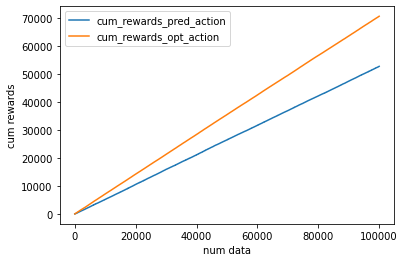

In [31]:
import matplotlib.pyplot as plt
plt.plot(cum_rewards_pred_action, label = 'cum_rewards_pred_action')
plt.plot(cum_rewards_opt_action, label = 'cum_rewards_opt_action')
plt.legend()
plt.xlabel('num data')
_ = plt.ylabel('cum rewards')

In [33]:
np.sum(pred_actions == opt_actions)/num_data

0.70799

Randomly choose 100000 from the data snippet. 
run the ContextualBandit on this sub dataset.
For every 1000 data points,
1. run the LinUCB
2. then train the Wide and Deep model on that 1000 data points for 100 epoches.
3. then update the LinUCB parameters (A matrix and B vector) according to all the seen data points in order to keep the LinUCB knowledge by far.
4. output the time spent on this 1000 data points.